In [1]:
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm.auto import tqdm
import tensorflow as tf
import imageio
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver

2024-03-18 23:52:49.672721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 23:52:50.583963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
RES = 500
lim = 5.0
tf.random.set_seed(42)
num_iterations = 100
population = 100

In [3]:
def save_populations(surf, populations, savedir):
    savedir = Path(savedir)
    populations_dir = savedir / "populations"
    populations_dir.mkdir(exist_ok=True, parents=True)
    surf.extract_surface().save(savedir / "surf.stl")
    for i, population in tqdm(enumerate(populations), total=len(populations)):
        file = populations_dir / f"{str(i).zfill(4)}.npy"
        #with open(file, "w") as f:
        np.save(file, population)

In [4]:
class Hills(tf.Module):

    def __init__(
        self, 
        x_min=-5.0, 
        x_max=5.0, 
        y_min=-5.0, 
        y_max=5.0, 
        radius_min=0.5,
        radius_max=2.0,
        height_min=0.1,
        height_max=1.0,
        n_hills=50,
    ):
        super().__init__()
        self.x0 = tf.random.uniform([1, n_hills], x_min, x_max, dtype=tf.float32)
        self.y0 = tf.random.uniform([1, n_hills], y_min, y_max, dtype=tf.float32)
        self.radius = tf.random.uniform([1, n_hills], radius_min, radius_max, dtype=tf.float32)
        self.height = tf.random.uniform([1, n_hills], height_min, height_max, dtype=tf.float32)
        
    #def cast(self, var, input_var):
    #    result = tf.ones_like(x)

    @tf.function(input_signature=[
        tf.TensorSpec([None,1], tf.float32),
        tf.TensorSpec([None,1], tf.float32),
    ])
    #@tf.function
    def __call__(self, x, y):
        print('Tracing with', x, y)
        distance = tf.sqrt((x - self.x0)**2 + (y - self.y0)**2)
        hills = self.height * tf.exp(-distance**2 / self.radius**2)
        return tf.math.reduce_sum(hills, axis=-1, keepdims=True)

In [5]:
hills = Hills(-lim, lim, -lim, lim)

2024-03-18 23:52:52.140881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
x = np.linspace(-lim, lim, RES, dtype=np.float32)
y = np.linspace(-lim, lim, RES, dtype=np.float32)
X, Y = np.meshgrid(x, y)

In [7]:
Z = hills(tf.reshape(X, (-1,1)), tf.reshape(Y, (-1,1))).numpy().reshape(X.shape)

Tracing with Tensor("x:0", shape=(None, 1), dtype=float32) Tensor("y:0", shape=(None, 1), dtype=float32)


/home/max/miniconda3/envs/dev/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning:

Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.



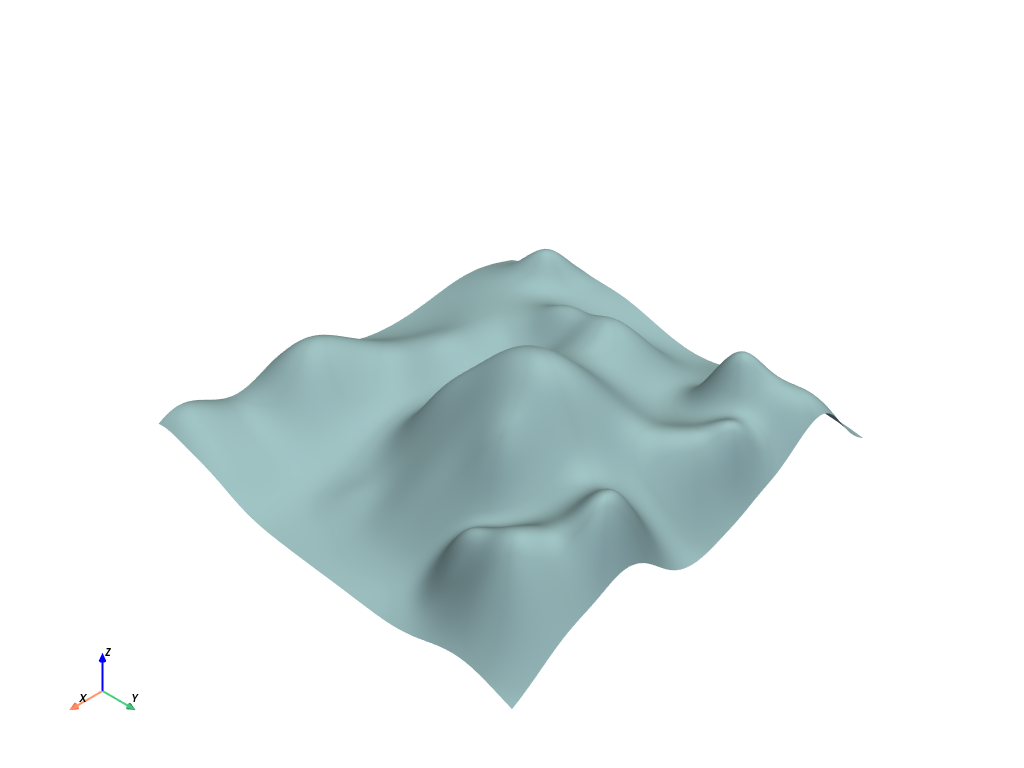

In [8]:
grid = pv.StructuredGrid(X, Y, Z)
grid.plot()

In [24]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.15)

In [25]:
inputs_x = tf.Variable(tf.random.uniform([population,1], -lim, lim, dtype=tf.float32))
inputs_y = tf.Variable(tf.random.uniform([population,1], -lim, lim, dtype=tf.float32))
populations = []
# Perform optimization
for _ in tqdm(range(num_iterations)):
    with tf.GradientTape() as tape:
        z = hills(inputs_x, inputs_y)
        loss = -z
        
    pts = np.hstack([inputs_x.numpy(), inputs_y.numpy(), z.numpy()])
    populations.append(pts)
    
    gradients = tape.gradient(loss, [inputs_x, inputs_y])
    optimizer.apply_gradients(zip(gradients, [inputs_x, inputs_y]))
    
save_populations(grid, populations, "grad_v3")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
class HillsProblem(FloatProblem):
    def __init__(self):
        super(HillsProblem, self).__init__()
        self.__number_of_variables = 2
        self.__number_of_objectives = 1
        self.__number_of_constraints = 0

        self.lower_bound = [-lim, -lim]
        self.upper_bound = [lim, lim]

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        x = tf.constant([[solution.variables[0]]])
        y = tf.constant([[solution.variables[1]]])
        fitness = -hills(x, y)
        solution.objectives[0] = fitness.numpy()[0]
        return solution
    
    def create_solution(self) -> FloatSolution:
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints)
        new_solution.variables = [
            random.uniform(
                self.lower_bound[i]*1.0, self.upper_bound[i]*1.0
            ) for i in range(self.number_of_variables)
        ]

        return new_solution

    #def get_name(self) -> str:
    #    return self.name
    
    @property
    def name(self) -> str:
        return self.__name
    
    @name.setter
    def name(self, name):
        self.__name = name
    
    @property
    def number_of_variables(self) -> int:
        return self.__number_of_variables
    
    @number_of_variables.setter
    def number_of_variables(self, number_of_variables):
        self.__number_of_variables = number_of_variables
    
    @property
    def number_of_objectives(self) -> int:
        return self.__number_of_objectives
    
    @number_of_objectives.setter
    def number_of_objectives(self, number_of_objectives):
        self.__number_of_objectives = number_of_objectives
    
    @property
    def number_of_constraints(self) -> int:
        return self.__number_of_constraints
    
    @number_of_constraints.setter
    def number_of_constraints(self, number_of_constraints):
        self.__number_of_constraints = number_of_constraints

In [10]:
class SolutionListObserver:
    def __init__(self):
        self.solutions = []

    def update(self, *args, **kwargs):
        solutions = kwargs["SOLUTIONS"]
        self.solutions.extend(solutions)

In [14]:
problem = HillsProblem()
max_evaluations = num_iterations * population
algorithm = NSGAII(
    problem=problem,
    population_size=population,
    offspring_population_size=population,
    mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=0.02),
    crossover=SBXCrossover(probability=1.0 / problem.number_of_variables, distribution_index=0.2),
    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
)

In [15]:
# Create an observer to track progress
progress_observer = ProgressBarObserver(max=max_evaluations)

# Create our custom observer to store intermediate solutions
solution_observer = SolutionListObserver()

# Add the observers to the algorithm
algorithm.observable.register(progress_observer)
algorithm.observable.register(solution_observer)

# Run the algorithm
algorithm.run()

# Retrieve and analyze the results
final_solutions = algorithm.get_result()

# Retrieve the intermediate solutions
intermediate_solutions = solution_observer.solutions

[2024-03-18 23:55:46,406] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-18 23:55:46,415] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-18 23:55:46,530] [jmetal.core.algorithm] [DEBUG] Initializing progress...
Progress: 100%|##########################| 10000/10000 [00:13<00:00, 727.88it/s]
[2024-03-18 23:56:00,272] [jmetal.core.algorithm] [DEBUG] Finished!


In [16]:
populations = []
for i in tqdm(range(num_iterations)):
    sols = intermediate_solutions[i*population : (i+1)*population]
    x = []
    y = []
    for sol in sols:
        x_tmp, y_tmp = sol.variables
        x.append(x_tmp)
        y.append(y_tmp)
    x = np.vstack(x)
    y = np.vstack(y)
    z = hills(x, y)
    populations.append(np.hstack([x, y, z]))
save_populations(grid, populations, "ga_v6")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]